Parsing Each Log Line

In [1]:
import re
import datetime

from pyspark.sql import Row

month_map = {'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
    'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12}

def parse_apache_time(s):
    """ Convert Apache time format into a Python datetime object
    Args:
        s (str): date and time in Apache time format
    Returns:
        datetime: datetime object (ignore timezone for now)
    """
    
    return datetime.datetime(int(s[0:4]),
                             int(s[5:7]),
                             int(s[8:10]),
                             int(s[11:13]),
                             int(s[14:16]),
                             int(s[17:19]))




def parseApacheLogLine(logline):
    """ Parse a line in the Apache Common Log format
    Args:
        logline (str): a line of text in the Apache Common Log format
    Returns:
        tuple: either a dictionary containing the parts of the Apache Access Log and 1,
               or the original invalid log line and 0
    """
    
    logline = logline + "\n"
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logline)

    if match is None:
        return (logline, 0)
      
    return (Row(
        date_time     = parse_apache_time(match.group(1)),
        s_ip          = match.group(2),
        cs_method     = match.group(3),
        cs_uri_stem   = match.group(4),
        cs_uri_query  = match.group(5),
        s_port        = match.group(6),
        cs_username   = match.group(7),
        c_ip          = match.group(8),
        user_agent    = match.group(9),
        response_code = int(match.group(10)),
        sc_substatus  = match.group(11),
        sc_win32_stat = match.group(12),
        time_taken    = match.group(13),
           
    ), 1)

In [2]:
# A regular expression pattern to extract fields from the log line
APACHE_ACCESS_LOG_PATTERN = '^(\S+\s\S+) (\S+) (\S+) (\S+) (\S+) (\S+) (\S+) (\S+) (\S+) (\S+) (\S+) (\S+) (\S+)'

Configuration and Initial RDD Creation

In [3]:
import sys
import os
import hashlib

class TestFailure(Exception):
  pass
class PrivateTestFailure(Exception):
  pass

class Test(object):
  passed = 0
  numTests = 0
  failFast = False
  private = False

  @classmethod
  def setFailFast(cls):
    cls.failFast = True

  @classmethod
  def setPrivateMode(cls):
    cls.private = True

  @classmethod
  def assertTrue(cls, result, msg=""):
    cls.numTests += 1
    if result == True:
      cls.passed += 1
      print "1 test passed."
    else:
      print "1 test failed. " + msg
      if cls.failFast:
        if cls.private:
          raise PrivateTestFailure(msg)
        else:
          raise TestFailure(msg)

  @classmethod
  def assertEquals(cls, var, val, msg=""):
    cls.assertTrue(var == val, msg)

  @classmethod
  def assertEqualsHashed(cls, var, hashed_val, msg=""):
    cls.assertEquals(cls._hash(var), hashed_val, msg)

  @classmethod
  def printStats(cls):
    print "{0} / {1} test(s) passed.".format(cls.passed, cls.numTests)

  @classmethod
  def _hash(cls, x):
    return hashlib.sha1(str(x)).hexdigest()


baseDir = os.path.join('data')
inputPath = os.path.join('HTWeblog/u_ex140803.log')
logFile = os.path.join(baseDir, inputPath)

def parseLogs():
    """ Read and parse log file """
    datafileWithComments = sc.textFile(logFile)
    datafileWithoutComments = datafileWithComments.filter(lambda line: not line.startswith("#"))
    
    parsed_logs = (datafileWithoutComments
                   .map(parseApacheLogLine)
                   .cache())

    access_logs = (parsed_logs
                   .filter(lambda s: s[1] == 1)
                   .map(lambda s: s[0])
                   .cache())

    failed_logs = (parsed_logs
                   .filter(lambda s: s[1] == 0)
                   .map(lambda s: s[0]))
    
    
    print(failed_logs)
    
    failed_logs_count = failed_logs.count()
    if failed_logs_count > 0:
        print 'Number of invalid logline: %d' % failed_logs.count()
        for line in failed_logs.take(20):
            print 'Invalid logline: %s' % line

    print 'Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (parsed_logs.count(), access_logs.count(), failed_logs.count())
    return parsed_logs, access_logs, failed_logs


parsed_logs, access_logs, failed_logs = parseLogs()

for line in access_logs.take(20):
    print line
    
    

PythonRDD[4] at RDD at PythonRDD.scala:43
Read 107520 lines, successfully parsed 107520 lines, failed to parse 0 lines
Row(c_ip=u'46.165.195.139', cs_method=u'GET', cs_uri_query=u'-', cs_uri_stem=u'/', cs_username=u'-', date_time=datetime.datetime(2014, 8, 3, 0, 0, 57), response_code=200, s_ip=u'10.130.0.12', s_port=u'80', sc_substatus=u'0', sc_win32_stat=u'0', time_taken=u'1731', user_agent=u'Pingdom.com_bot_version_1.4_(http://www.pingdom.com/)')
Row(c_ip=u'66.249.69.192', cs_method=u'GET', cs_uri_query=u'-', cs_uri_stem=u'/location-and-contacts.aspx', cs_username=u'-', date_time=datetime.datetime(2014, 8, 3, 0, 1, 30), response_code=200, s_ip=u'10.130.0.12', s_port=u'80', sc_substatus=u'0', sc_win32_stat=u'0', time_taken=u'921', user_agent=u'Mozilla/5.0+(compatible;+Googlebot/2.1;++http://www.google.com/bot.html)')
Row(c_ip=u'212.84.74.156', cs_method=u'GET', cs_uri_query=u'-', cs_uri_stem=u'/', cs_username=u'-', date_time=datetime.datetime(2014, 8, 3, 0, 1, 57), response_code=200, 

Sample Analyses on the Web Server Log File

Response Code Analysis

In [4]:
responseCodeToCount = (access_logs
                       .map(lambda log: (log.response_code, 1))
                       .reduceByKey(lambda a, b : a + b)
                       .cache())
responseCodeToCountList = responseCodeToCount.take(100)
print 'Found %d response codes' % len(responseCodeToCountList)
print 'Response Code Counts: %s' % responseCodeToCountList

Found 7 response codes
Response Code Counts: [(304, 3027), (200, 101798), (302, 633), (400, 3), (403, 5), (404, 1955), (500, 99)]


Response Code Graphing with matplotlib

In [5]:
labels = responseCodeToCount.map(lambda (x, y): x).collect()
print labels
count = access_logs.count()
fracs = responseCodeToCount.map(lambda (x, y): (float(y) / count)).collect()
print fracs

[304, 200, 302, 400, 403, 404, 500]
[0.028152901785714286, 0.9467819940476191, 0.005887276785714286, 2.7901785714285713e-05, 4.650297619047619e-05, 0.018182663690476192, 0.0009207589285714286]


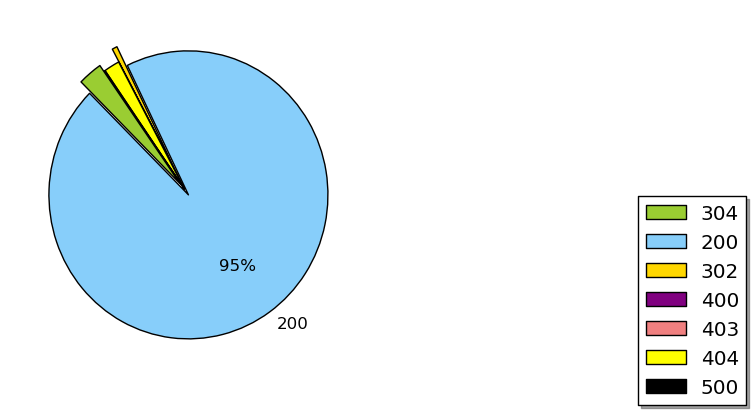

In [6]:
import matplotlib.pyplot as plt


def pie_pct_format(value):
    """ Determine the appropriate format string for the pie chart percentage label
    Args:
        value: value of the pie slice
    Returns:
        str: formated string label; if the slice is too small to fit, returns an empty string for label
    """
    return '' if value < 7 else '%.0f%%' % value

fig = plt.figure(figsize=(4.5, 4.5), facecolor='white', edgecolor='white')
colors = ['yellowgreen', 'lightskyblue', 'gold', 'purple', 'lightcoral', 'yellow', 'black']
explode = (0.05, 0.05, 0.1, 0, 0, 0, 0)
patches, texts, autotexts = plt.pie(fracs, labels=labels, colors=colors,
                                    explode=explode, autopct=pie_pct_format,
                                    shadow=False,  startangle=125)
for text, autotext in zip(texts, autotexts):
    if autotext.get_text() == '':
        text.set_text('')  # If the slice is small to fit, don't show a text label
plt.legend(labels, loc=(1.80, -0.1), shadow=True)
pass

Frequent Clients

In [7]:
# Any clients that has accessed the server more than 10 times.
clientCountPairTuple = access_logs.map(lambda log: (log.c_ip, 1))

clientSum = clientCountPairTuple.reduceByKey(lambda a, b : a + b)

clientMoreThan10 = clientSum.filter(lambda s: s[1] > 10)

clientsPick20 = (clientMoreThan10
               .map(lambda s: s[0])
               .take(20))

print 'Any 20 clients that have accessed more than 10 times: %s' % clientsPick20

Any 20 clients that have accessed more than 10 times: [u'210.176.55.252', u'176.62.66.69', u'14.0.209.179', u'1.36.189.14', u'1.36.241.51', u'49.180.161.31', u'62.203.72.24', u'70.112.58.3', u'109.147.174.125', u'112.118.127.122', u'24.233.223.167', u'123.202.95.135', u'183.171.168.79', u'99.106.234.73', u'218.102.224.167', u'106.169.150.36', u'202.140.108.107', u'86.153.161.205', u'115.164.94.87', u'219.77.194.124']


Visualizing Endpoints

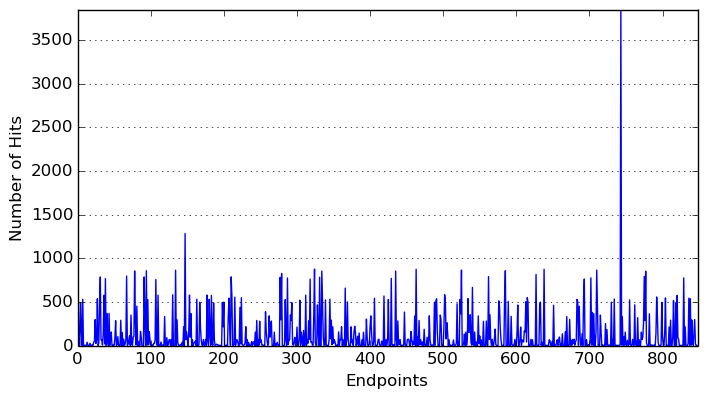

In [8]:
%matplotlib inline 

endpoints = (access_logs
             .map(lambda log: (log.cs_uri_stem, 1))
             .reduceByKey(lambda a, b : a + b)
             .cache())
ends = endpoints.map(lambda (x, y): x).collect()
counts = endpoints.map(lambda (x, y): y).collect()

fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, len(ends), 0, max(counts)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Endpoints')
plt.ylabel('Number of Hits')
plt.plot(counts)
pass

Top Endpoints

In [9]:
endpointCounts = (access_logs
                  .map(lambda log: (log.cs_uri_stem, 1))
                  .reduceByKey(lambda a, b : a + b))

topEndpoints = endpointCounts.takeOrdered(10, lambda s: -1 * s[1])

print 'Top Ten Endpoints: %s' % topEndpoints
#assert topEndpoints == [(u'/images/NASA-logosmall.gif', 59737), (u'/images/KSC-logosmall.gif', 50452), (u'/images/MOSAIC-logosmall.gif', 43890), (u'/images/USA-logosmall.gif', 43664), (u'/images/WORLD-logosmall.gif', 43277), (u'/images/ksclogo-medium.gif', 41336), (u'/ksc.html', 28582), (u'/history/apollo/images/apollo-logo1.gif', 26778), (u'/images/launch-logo.gif', 24755), (u'/', 20292)], 'incorrect Top Ten Endpoints'

Top Ten Endpoints: [(u'/', 3849), (u'/404.aspx', 1283), (u'/js/jquery/jquery.js', 875), (u'/js/jquery/jquery.cycle.all.js', 873), (u'/js/jquery/jquery.colorbox-min.js', 873), (u'/js/jquery/jquery.easing.js', 864), (u'/js/jquery/jquery-ui-1.8.20.custom.min.js', 863), (u'/js/jquery/jquery.jscrollpane.min.js', 863), (u'/js/global.js', 856), (u'/js/jquery/jquery.validate.js', 856)]


 Top Ten Error Endpoints

In [10]:
not200 = access_logs.filter(lambda x: x.response_code != 200)
endpointCountPairTuple = not200.map(lambda log: (log.cs_uri_stem, 1))

endpointSum = endpointCountPairTuple.reduceByKey(lambda a, b: a + b)

topTenErrURLs = endpointSum.takeOrdered(10, lambda (k, v): -1 * v)
print 'Top Ten failed URLs: %s' % topTenErrURLs

Top Ten failed URLs: [(u'/favicon.ico', 813), (u'/404.aspx', 649), (u'/', 371), (u'/PIE/PIE.htc', 100), (u'/default.aspx', 77), (u'/apple-touch-icon.png', 76), (u'/js/jquery/jquery.cycle.all.js', 75), (u'/js/jquery/jquery.dropkick.js', 70), (u'/js/jquery/jquery.js', 70), (u'/js/jquery/jquery.validate.js', 70)]


Number of Unique Clients

In [11]:
clients = access_logs.map(lambda x: (x.c_ip, 1))
print(clients.take(20))
uniqueClients = clients.reduceByKey(lambda a, b: a)

uniqueClientCount = uniqueClients.count()
print 'Unique clients: %d' % uniqueClientCount

[(u'46.165.195.139', 1), (u'66.249.69.192', 1), (u'212.84.74.156', 1), (u'14.136.194.139', 1), (u'14.136.194.139', 1), (u'14.136.194.139', 1), (u'14.136.194.139', 1), (u'14.136.194.139', 1), (u'14.136.194.139', 1), (u'14.136.194.139', 1), (u'14.136.194.139', 1), (u'14.136.194.139', 1), (u'14.136.194.139', 1), (u'14.136.194.139', 1), (u'14.136.194.139', 1), (u'14.136.194.139', 1), (u'14.136.194.139', 1), (u'14.136.194.139', 1), (u'14.136.194.139', 1), (u'14.136.194.139', 1)]
Unique clients: 2382


Number of Unique Daily Clients

In [12]:
#Get unique (day, client) pairs
dayToClientPairTuple = (access_logs
                        .map(lambda x: ((x.date_time.day, x.c_ip), 1)))

dayGroupedClients = (dayToClientPairTuple
                    # Remove duplicate day/client combination
                    .reduceByKey(lambda a, b: a)
                    # Remove ls
                    .map(lambda (k, v): k))
                    # Left with unique (day, client) pairs ...
    
dayClientCount = (dayGroupedClients
                # Replace clients with 1
                .map(lambda (day, client): (day, 1))
                # Count ls for each day
                .reduceByKey(lambda a, b: a + b))

dailyClients = dayClientCount.sortByKey().cache()
dailyClientsList = dailyClients.take(30)
print 'Unique Clients per day: %s' % dailyClientsList

Unique Clients per day: [(3, 2382)]


Visualizing the Number of Unique Daily Clients

In [13]:
daysWithClients = dailyClients.map(lambda (day, count): day).collect()
clients = dailyClients.map(lambda (day, count): count).collect()


In [ ]:
fig = plt.figure(figsize=(8,4.5), facecolor='white', edgecolor='white')
plt.axis([min(daysWithClients), max(daysWithClients), 0, max(clients)+500])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('Clients')
plt.plot(daysWithClients, clients)
pass

Average Number of Daily Requests per Client

In [15]:
dayAndClientTuple = access_logs.map(lambda x: (x.date_time.day, x.c_ip))

groupedByDay = dayAndClientTuple.groupByKey()

sortedByDay = groupedByDay.sortByKey()

avgDailyReqPerClient = (sortedByDay
                      .map(lambda (day, clients): (day, len(clients)/len(set(clients))))
                      .cache())
avgDailyReqPerClientList = avgDailyReqPerClient.take(30)
print 'Average number of daily requests per Client is %s' % avgDailyReqPerClientList

Average number of daily requests per Client is [(3, 45)]


Visualizing the Average Daily Requests per Unique Client

In [16]:
daysWithAvg = avgDailyReqPerClient.map(lambda (day, avg): day).collect()
avgs = avgDailyReqPerClient.map(lambda(day, avg): avg).collect()

In [ ]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(daysWithAvg), 0, max(avgs)+2])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('Average')
plt.plot(daysWithAvg, avgs)
pass

Exploring 404 Response Codes

Counting 404 Response Codes

In [18]:
badRecords = (access_logs
              .filter(lambda x: x.response_code == 404)
              .cache())
print 'Found %d 404 URLs' % badRecords.count()

Found 1955 404 URLs


Listing 404 Response Code Records

In [19]:
badEndpoints = badRecords.map(lambda x: x.cs_uri_stem)

badUniqueEndpoints = badEndpoints.distinct()

badUniqueEndpointsPick40 = badUniqueEndpoints.take(40)
print '404 URLS: %s' % badUniqueEndpointsPick40

404 URLS: [u'/location-and-contacts/', u'/facilities/', u'/bitrix/js/main/core/core.css', u'/privacy/', u'/templates/system/css/system.css', u'/wordpress/', u'/netcat/admin/skins/default/css/login.css', u'/zh-cn/css/fonts/pfbeausanspro-book-webfont.svg', u'/manager/templates/default/images/restyle/headers.jpg', u'/modules/system/system.css', u'/users/registrate/', u'/home/privacy/', u'/ru-ru/css/social-media.css', u'/user/password/', u'/styles/skins/mac/design/css/style.css', u'/wp-login.php', u'/apple-touch-icon-114x114-precomposed.png', u'/apple-touch-icon-76x76-precomposed.png', u'/zh-tw/css/fonts/pfbeausanspro-book-webfont.svg', u'/sitemap/careers-and-education/', u'/manager/media/style/MODxCarbon/images/misc/logo.png', u'/careers-and-education/', u'/zh-cn/css/fonts/pfbeausanspro-book-webfont.ttf', u'/google-maps-', u'/administrator/index.php', u'/manager/', u'/above-and-beyond/', u'/manager/media/script/mootools/mootools.js', u'/en/css/social-media.css', u'/our-city/privacy/', u'/

Listing the Top Twenty 404 Response Code Endpoints

In [20]:
badEndpointsCountPairTuple = badRecords.map(lambda x: (x.cs_uri_stem, 1))

badEndpointsSum = badEndpointsCountPairTuple.reduceByKey(lambda a, b: a + b)

badEndpointsTop20 = badEndpointsSum.takeOrdered(20, lambda (a, b): -1 * b)
print 'Top Twenty 404 URLs: %s' % badEndpointsTop20

Top Twenty 404 URLs: [(u'/favicon.ico', 813), (u'/404.aspx', 640), (u'/PIE/PIE.htc', 100), (u'/apple-touch-icon.png', 76), (u'/apple-touch-icon-precomposed.png', 50), (u'/zh-tw/css/fonts/pfbeausanspro-book-webfont.ttf', 47), (u'/zh-tw/css/fonts/pfbeausanspro-book-webfont.svg', 34), (u'/zh-tw/css/fonts/pfbeausanspro-book-webfont.eot', 33), (u'/favicon.gif', 11), (u'/wp-login.php', 10), (u'/maps.googleapis.com/maps/api/js', 7), (u'/zh-cn/css/fonts/pfbeausanspro-book-webfont.ttf', 5), (u'/dining/', 5), (u'/facilities/', 4), (u'/zh-cn/css/fonts/pfbeausanspro-book-webfont.svg', 4), (u'/careers-and-education/', 4), (u'/en/css/fonts/pfbeausanspro-book-webfont.svg', 4), (u'/administrator/index.php', 3), (u'/above-and-beyond/', 3), (u'/wp-trackback.php', 3)]


Listing the Top Twenty-five 404 Response Code Clients

In [23]:
errClientsCountPairTuple = badRecords.map(lambda x: (x.c_ip, 1))

errClientsSum = errClientsCountPairTuple.reduceByKey(lambda a, b: a + b)

errClientsTop25 = errClientsSum.takeOrdered(25, lambda(host, count): -1 * count)
print 'Top 25 Clients that encountered errors: %s' % errClientsTop25

Top 25 Clients that encountered errors: [(u'14.136.194.139', 189), (u'183.179.148.240', 44), (u'14.0.143.20', 38), (u'178.210.65.38', 34), (u'119.237.182.169', 30), (u'182.239.77.36', 28), (u'126.204.42.117', 28), (u'58.153.210.15', 24), (u'210.6.200.26', 23), (u'219.79.4.141', 22), (u'119.247.123.105', 22), (u'61.18.70.12', 20), (u'42.2.131.200', 20), (u'112.118.5.102', 20), (u'120.88.255.86', 18), (u'120.88.228.118', 16), (u'42.3.117.42', 16), (u'219.79.163.194', 14), (u'223.62.212.65', 14), (u'49.180.161.31', 12), (u'133.202.77.222', 12), (u'119.236.207.54', 12), (u'119.246.58.211', 10), (u'202.140.108.81', 10), (u'113.253.255.250', 10)]


Listing 404 Response Codes per Day

In [24]:
errDateCountPairTuple = badRecords.map(lambda x: (x.date_time.day, 1))

errDateSum = errDateCountPairTuple.reduceByKey(lambda a, b: a + b)

errDateSorted = errDateSum.sortByKey().cache()
                 
errByDate = errDateSorted.collect()
print '404 Errors by day: %s' % errByDate

404 Errors by day: [(3, 1955)]


Visualizing the 404 Response Codes by Day

In [26]:
daysWithErrors404 = (errDateSorted.
                     map(lambda (day, count): day)
                    .collect())
errors404ByDay = (errDateSorted
                .map(lambda (day, count): count)
                .collect())

In [ ]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(daysWithErrors404), 0, max(errors404ByDay)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('404 Errors')
plt.plot(daysWithErrors404, errors404ByDay)
pass

 Hourly 404 Response Codes

In [32]:
hourCountPairTuple = badRecords.map(lambda x: (x.date_time.hour, 1))

hourRecordsSum = hourCountPairTuple.reduceByKey(lambda a, b: a + b)

hourRecordsSorted = (hourRecordsSum
                     .sortByKey()
                     .cache())

errHourList = hourRecordsSorted.collect()
print 'Top hours for 404 requests: %s' % errHourList

Top hours for 404 requests: [(0, 37), (1, 54), (2, 90), (3, 75), (4, 75), (5, 103), (6, 99), (7, 124), (8, 134), (9, 136), (10, 80), (11, 87), (12, 126), (13, 163), (14, 80), (15, 134), (16, 165), (17, 41), (18, 34), (19, 17), (20, 18), (21, 16), (22, 47), (23, 20)]


Visualizing the 404 Response Codes by Hour

In [33]:
hoursWithErrors404 = (hourRecordsSorted
            .map(lambda (hour, count): hour)
            .collect())
errors404ByHours = (hourRecordsSorted
                    .map(lambda (hour, count): count)
                    .collect())

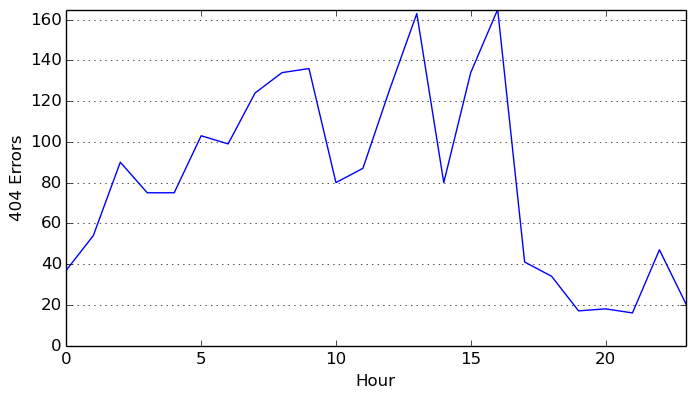

In [34]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(hoursWithErrors404), 0, max(errors404ByHours)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Hour')
plt.ylabel('404 Errors')
plt.plot(hoursWithErrors404, errors404ByHours)
pass

In [25]:
labels = responseCodeToCount.map(lambda (x, y): x).collect()
print labels
count = access_logs.count()
fracs = responseCodeToCount.map(lambda (x, y): (float(y) / count)).collect()

print fracs

[304, 200, 302, 400, 403, 404, 500]
107520
[0.028152901785714286, 0.9467819940476191, 0.005887276785714286, 2.7901785714285713e-05, 4.650297619047619e-05, 0.018182663690476192, 0.0009207589285714286]


(-1, 7)

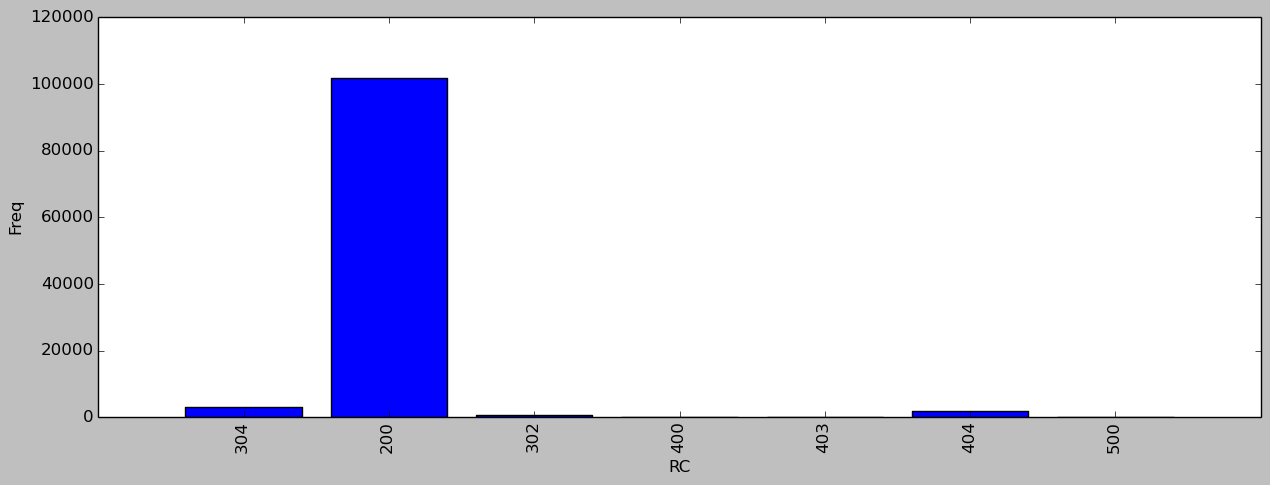

In [27]:
# Response code
import numpy as np

labels = responseCodeToCount.map(lambda (x, y): x).collect()


# frequency count opf response codes
xx = responseCodeToCount.map(lambda (x, y): y).collect()
xx_pos = np.arange(len(xx))

fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(xx_pos, xx, align='center')
ax.set_xlabel("RC")
ax.set_ylabel("Freq")
ax.set_xticks(xx_pos)
ax.set_xticklabels(labels, rotation=90)
ax.set_xlim(-1, len(xx))